In [ ]:
import numpy as np
import pandas as pd
import os
from mario_scenes.load_data import load_scenes_info
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
scenes_df = load_scenes_info(format='df')
# drop last row
scenes_df = scenes_df.drop(scenes_df.index[-1])
# convert World Level and Scene to int
scenes_df['World'] = scenes_df['World'].astype(int)
scenes_df['Level'] = scenes_df['Level'].astype(int)
scenes_df['Scene'] = scenes_df['Scene'].astype(int)
# create scene_id column
scenes_df['scene_id'] = scenes_df['World'].astype(str) + '-' + scenes_df['Level'].astype(str) + '-' + scenes_df['Scene'].astype(str)
# drop non-pattern columns
scenes_df = scenes_df.drop(columns=['World', 'Level', 'Scene', 'x Hi (entry)', 'x Lo (entry)', 'x Hi (exit)', 'x Lo (exit)', 'Entry point', 'Exit point', 'Layout', 'Checkpoint'])

# load clustering from pkl file
cluster_file = '../outputdata/clusters.pkl'
with open(cluster_file, 'rb') as f:
    clusters = pkl.load(f)
clusters[20]['index']

scenes_df['Cluster'] = clusters[20]['index']

scenes_df

,Enemy,2-Horde,3-Horde,4-Horde,Roof,Gap,Multiple gaps,Variable gaps,Gap enemy,Pillar gap,...,Enemy stair valley,Gap stair valley,Reward,Moving platform,Flagpole,Beginning,Bonus zone,Waterworld,scene_id,Cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1-1-0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1-1-1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1-1-2,2
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1-1-3,3
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1-1-4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8-3-7,9
309,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8-3-8,20
310,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8-3-9,20
311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8-3-10,3


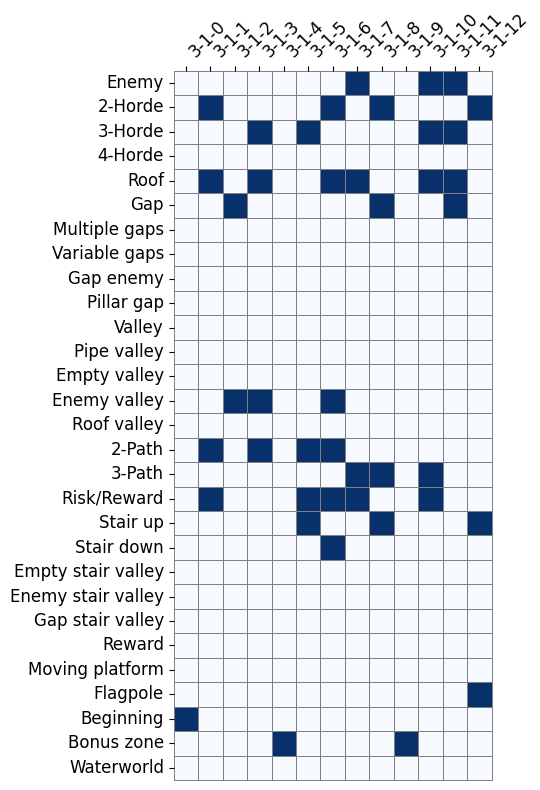

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = scenes_df.copy().drop(columns=['Cluster'])
mask   = df['scene_id'].str.startswith('3-1-')
subset = df.loc[mask].set_index('scene_id').T  # Transpose

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(
    subset,
    cmap='Blues', vmin=0, vmax=1,
    linewidths=0.5, linecolor='grey',
    cbar=False,
    ax=ax,
    square=True,
    clip_on=False
)

# Move x-axis labels to the top with bigger tilted text
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left', fontsize=12)

# Y-axis (pattern names) font size
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

# Remove axis labels
ax.set_ylabel("")
ax.set_xlabel("")

plt.tight_layout()
plt.savefig('../outputdata/figures/pattern_annotations_3-1.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()


/tmp/ipykernel_98132/1660389090.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar without excess padding


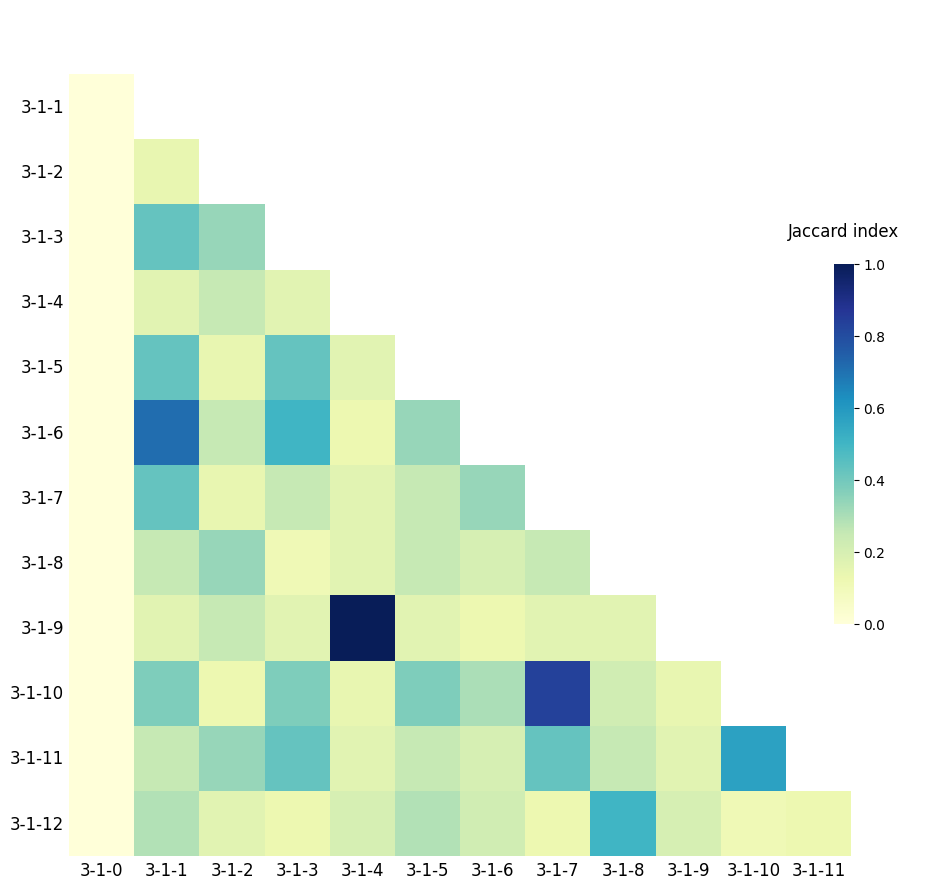

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# Work on a copy
df_copy = scenes_df.copy()

# Keep only 3-1-* scenes
subset_mask = df_copy['scene_id'].str.startswith('3-1-')
subset_df = df_copy[subset_mask].set_index('scene_id')

# Ensure binary feature matrix
binary_features = subset_df.select_dtypes(include=np.number).astype(bool).astype(int)

# Compute Jaccard similarity matrix
n = len(binary_features)
jaccard_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        jaccard_matrix[i, j] = jaccard_score(binary_features.iloc[i], binary_features.iloc[j])

# Scene labels, adjusted for shown part only
scene_labels = binary_features.index.tolist()
xticks_labels = scene_labels[:-1] + ['']
yticks_labels = [''] + scene_labels[1:]

# Mask top triangle including diagonal
mask = np.triu(np.ones_like(jaccard_matrix, dtype=bool))

# Plot with custom layout
fig, ax = plt.subplots(figsize=(10, 9))
cbar_ax = fig.add_axes([0.8, 0.3, 0.02, 0.4])  # [left, bottom, width, height] — closer to heatmap

sns.heatmap(
    jaccard_matrix,
    cmap='YlGnBu',
    square=True,
    mask=mask,
    cbar=True,
    cbar_ax=cbar_ax,
    xticklabels=xticks_labels,
    yticklabels=yticks_labels,
    ax=ax
)

# Remove tick marks but keep labels
ax.tick_params(axis='both', which='both', length=0)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
cbar_ax.set_title("Jaccard index", pad=20)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar without excess padding
plt.savefig('../outputdata/figures/jaccard_scenes_3-1.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

In [ ]:
## Heatmap with scenes ordered by level
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# Convert to binary
df = scenes_df.copy()
binary_df = df.astype(bool).astype(int)

# Compute Jaccard similarity matrix
n = len(binary_df)
jaccard_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        jaccard_matrix[i, j] = jaccard_score(binary_df.iloc[i], binary_df.iloc[j])




In [ ]:
# Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    jaccard_df,
    cmap='YlGnBu',
    square=True,
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    mask=mask
)

# Clean axes
ax.set_xlabel("")
ax.set_ylabel("")

n = len(jaccard_df)
for pos in boundary_positions:
    # Horizontal line: from left to just before the diagonal
    ax.plot([0, pos], [pos, pos], color='black', linewidth=1.2, clip_on=False)
    
    # Vertical line: from diagonal down to the bottom
    ax.plot([pos, pos], [pos + 1e-6, n], color='black', linewidth=1.2, clip_on=False)


ax.set_xticklabels([])
ax.set_yticklabels([])

# Manually add level names at block centers
n = len(jaccard_df)
for pos, name in zip(level_positions, level_names):
    ax.text(pos, n + 12, name, ha='center', va='bottom', fontsize=12)  # X axis (bottom)
    ax.text(-5, pos, name, ha='right', va='center', fontsize=12)                   # Y axis

plt.tight_layout()
plt.show()


AttributeError: 'int' object has no attribute 'split'

In [21]:
# --- Get cluster boundaries and names ---
cluster_labels = df['Cluster'].loc[sorted_indices].tolist()
cluster_boundaries = [i for i in range(1, len(cluster_labels)) if cluster_labels[i] != cluster_labels[i-1]]
cluster_ticks = [0] + cluster_boundaries + [len(cluster_labels)]
cluster_names = sorted(set(cluster_labels), key=cluster_labels.index)

# Compute cluster center positions
cluster_positions = [(cluster_ticks[i] + cluster_ticks[i+1]) / 2 for i in range(len(cluster_names))]
boundary_positions = [tick - 0.5 for tick in cluster_ticks[1:-1]]  # don't include outer borders

# --- Mask lower triangle and diagonal ---
mask = np.tril(np.ones_like(jaccard_df, dtype=bool))

# --- Plot heatmap ---
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    jaccard_df,
    cmap='YlGnBu',
    square=True,
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    mask=mask
)

# --- Draw horizontal/vertical lines ABOVE the diagonal ---
for pos in boundary_positions:
    # Horizontal: from pos+1 to right edge
    ax.plot([pos+1, n], [pos, pos], color='black', linewidth=1.2, clip_on=False)
    # Vertical: from top to pos-1
    ax.plot([pos, pos], [0, pos], color='black', linewidth=1.2, clip_on=False)

# --- Add cluster labels ---
for pos, name in zip(cluster_positions, sorted(set(cluster_labels))):
    ax.text(pos, -5, f"{name}", ha='center', va='top', fontsize=12)       # Top (X axis)
    ax.text(n + 2, pos, f"{name}", ha='left', va='center', fontsize=12)   # Right (Y axis)

# Final polish
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
plt.show()


KeyError: 'Cluster'

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score

# Work on a copy
df = scenes_df.copy()

# Keep only binary features
binary_df = df.select_dtypes(include=np.number).drop(columns=['Cluster'], errors='ignore')
binary_df = binary_df.astype(bool).astype(int)

# Store the scene IDs
scene_ids = df['scene_id']

# Compute Jaccard similarity matrix
n = len(binary_df)
jaccard_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        jaccard_matrix[i, j] = jaccard_score(binary_df.iloc[i], binary_df.iloc[j])

# Build DataFrame
jaccard_df = pd.DataFrame(jaccard_matrix, index=scene_ids, columns=scene_ids)


/home/hyruuk/mambaforge/envs/mario_scenes/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hyruuk/mambaforge/envs/mario_scenes/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hyruuk/mambaforge/envs/mario_scenes/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

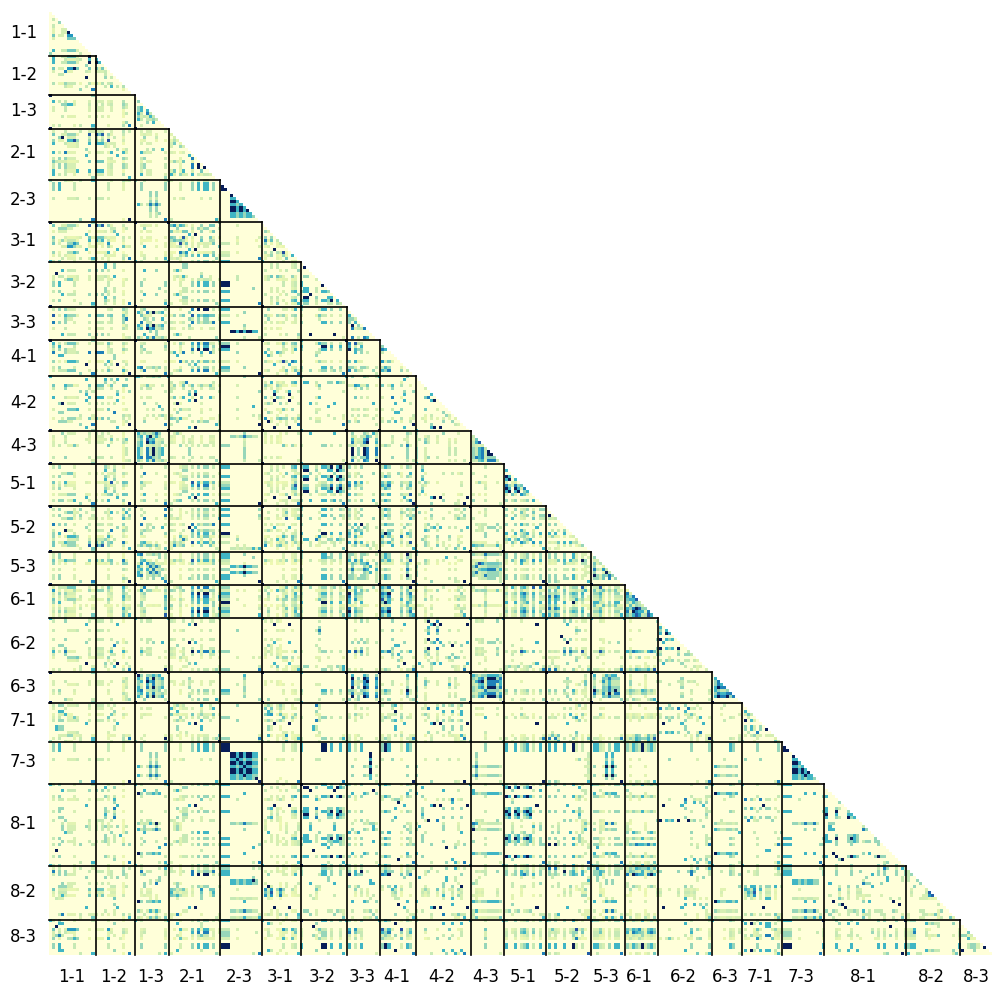

In [40]:
# Sort by scene_ids (default order should reflect level order)
jaccard_df_levels = jaccard_df.copy()
scene_ids = jaccard_df_levels.index.tolist()

# Extract level codes (e.g. '3-1') from scene IDs
level_labels = [scene.split('-')[0] + '-' + scene.split('-')[1] for scene in scene_ids]

# Find level boundaries
level_boundaries = [i for i in range(1, len(level_labels)) if level_labels[i] != level_labels[i-1]]
level_ticks = [0] + level_boundaries + [len(level_labels)]
level_names = sorted(set(level_labels), key=level_labels.index)
level_positions = [(level_ticks[i] + level_ticks[i+1]) / 2 for i in range(len(level_names))]
boundary_positions = [tick + 0.5 for tick in level_ticks[1:-1]]

# Create mask for upper triangle and diagonal
mask = np.triu(np.ones_like(jaccard_df_levels, dtype=bool))

# Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    jaccard_df_levels,
    cmap='YlGnBu',
    square=True,
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    mask=mask
)

# Draw separator lines (lower triangle)
n = len(jaccard_df_levels)
for pos in boundary_positions:
    ax.plot([0, pos], [pos, pos], color='black', linewidth=1.2, clip_on=False)        # Horizontal
    ax.plot([pos, pos], [pos + 1e-6, n], color='black', linewidth=1.2, clip_on=False)  # Vertical

# Add level labels
for pos, name in zip(level_positions, level_names):
    ax.text(pos, n + 10, name, ha='center', va='bottom', fontsize=12)   # Bottom X
    ax.text(-4, pos, name, ha='right', va='center', fontsize=12)        # Left Y

# Final touches
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()
plt.savefig('../outputdata/figures/jaccard_scenes_levels.png', dpi=300, transparent=True)
plt.show()


/home/hyruuk/mambaforge/envs/mario_scenes/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hyruuk/mambaforge/envs/mario_scenes/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hyruuk/mambaforge/envs/mario_scenes/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

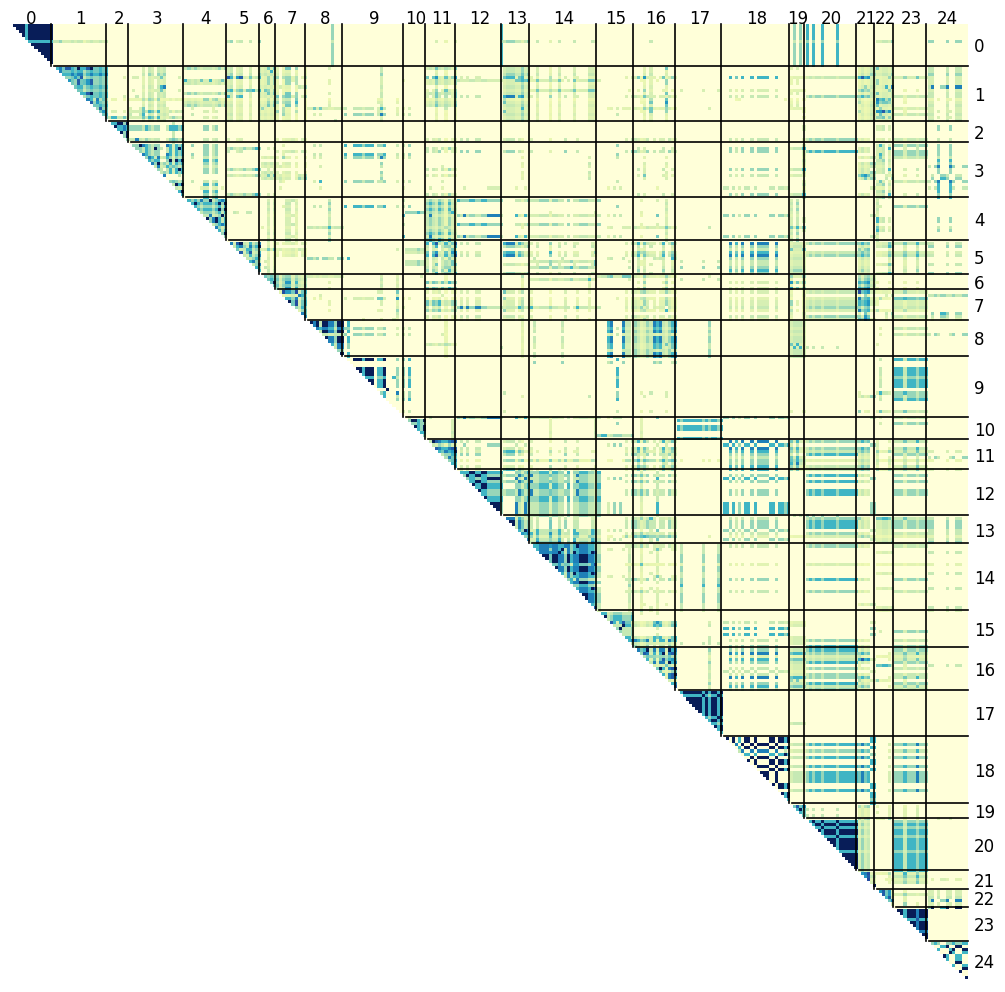

In [25]:
## Heatmap with scenes ordered by cluster
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# --- Prepare binary matrix ---
df = scenes_df.copy()
binary_df = df.select_dtypes(include=np.number).drop(columns=['Cluster'], errors='ignore')
binary_df = binary_df.astype(bool).astype(int)

# --- Reorder by cluster ---
scene_ids = df['scene_id']
clusters = df['Cluster']
sorted_indices = clusters.sort_values().index
sorted_scene_ids = scene_ids.loc[sorted_indices]
binary_df = binary_df.loc[sorted_indices]

# --- Compute Jaccard similarity matrix ---
n = len(binary_df)
jaccard_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        jaccard_matrix[i, j] = jaccard_score(binary_df.iloc[i], binary_df.iloc[j])

jaccard_df = pd.DataFrame(jaccard_matrix, index=sorted_scene_ids, columns=sorted_scene_ids)




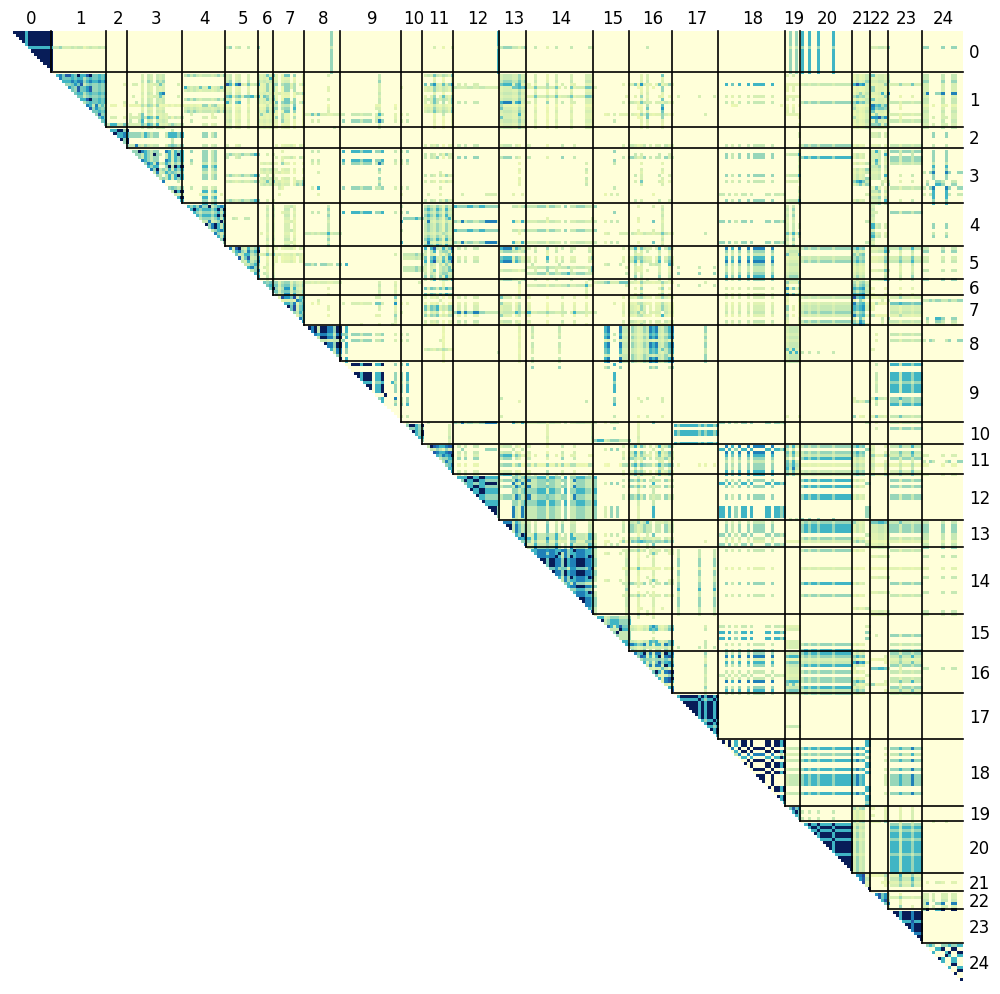

In [34]:
# Ensure the cluster column exists
#df = scenes_df.copy()
cluster_series = df.set_index('scene_id').loc[jaccard_df.index]['Cluster']

# Sort scene IDs by cluster assignment
sorted_scene_ids = cluster_series.sort_values().index.tolist()
jaccard_df_clusters = jaccard_df.loc[sorted_scene_ids, sorted_scene_ids]
cluster_labels = cluster_series.loc[sorted_scene_ids].tolist()

# Determine cluster boundaries
cluster_boundaries = [i for i in range(1, len(cluster_labels)) if cluster_labels[i] != cluster_labels[i-1]]
cluster_ticks = [0] + cluster_boundaries + [len(cluster_labels)]
cluster_names = sorted(set(cluster_labels), key=cluster_labels.index)
cluster_positions = [(cluster_ticks[i] + cluster_ticks[i+1]) / 2 for i in range(len(cluster_names))]
boundary_positions = [tick - 0.5 for tick in cluster_ticks[1:-1]]

# Create mask for lower triangle and diagonal
mask = np.tril(np.ones_like(jaccard_df_clusters, dtype=bool))

# Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    jaccard_df_clusters,
    cmap='YlGnBu',
    square=True,
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    mask=mask
)

# Draw separator lines (upper triangle)
n = len(jaccard_df_clusters)
for pos in boundary_positions:
    ax.plot([pos, n], [pos, pos], color='black', linewidth=1.2, clip_on=False)  # Horizontal
    ax.plot([pos, pos], [0, pos], color='black', linewidth=1.2, clip_on=False)      # Vertical

# Add cluster labels
for pos, name in zip(cluster_positions, sorted(set(cluster_labels))):
    ax.text(pos, -7, f"{name}", ha='center', va='top', fontsize=12)       # Top (X)
    ax.text(n + 2, pos, f"{name}", ha='left', va='center', fontsize=12)   # Right (Y)

# Final touches
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()
plt.savefig('../outputdata/figures/jaccard_scenes_clusters20.png', dpi=300, transparent=True)
plt.show()